## Colorado Oil & Gas Drilling Permits
##### Investigating how the number of Drilling permits changed over the past year (June 2016-June 2017)

* Has the new administration had an effect on the permit approval process?
* Has the number of permit requests increased?

In [62]:
from __future__ import division
import pandas as pd
import numpy as np
from datetime import timedelta
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
%matplotlib inline

#### Data Import

In [63]:
# Import Colorado Oil & Gas Well permits approved 6/8/16 - 6/30/17
# https://cogcc.state.co.us/COGIS/drillingpermits.asp
df_wells = pd.read_csv("data/CO_Well_Permits_2016-06-08_2017-06-30.csv")

df_wells.head()

,Received Posted,Operator Name Number,Operator Contact,Approved Date API No. (Scout Card Link),Type of Permit,Well Name/Number,Objective Formation,Proposed TD,Well Location,Footage Call,Field,County
0,03/29/2017\n04/10/2017,PDC ENERGY INC\n69175,Ally Gale \n(303) 831-3931,06/30/2017\n05-123-45084-00,DR,Schmier\n32H-232,NIOBRARA,16739,SWSW 32 5N 64W,704 FSL 347 FWL,WATTENBERG\n90750,WELD
1,03/29/2017\n04/10/2017,PDC ENERGY INC\n69175,Ally Gale \n(303) 831-3931,06/30/2017\n05-123-45081-00,DR,Schmier\n32H-302,NIOBRARA,17054,SWSW 32 5N 64W,719 FSL 347 FWL,WATTENBERG\n90750,WELD
2,03/29/2017\n04/10/2017,PDC ENERGY INC\n69175,Ally Gale \n(303) 831-3931,06/30/2017\n05-123-45082-00,DR,Schmier\n32i-302,NIOBRARA,16917,SWSW 32 5N 64W,659 FSL 347 FWL,WATTENBERG\n90750,WELD
3,03/29/2017\n04/10/2017,PDC ENERGY INC\n69175,Ally Gale \n(303) 831-3931,06/30/2017\n05-123-45083-00,DR,Schmier\n32i-212,NIOBRARA,16744,SWSW 32 5N 64W,674 FSL 347 FWL,WATTENBERG\n90750,WELD
4,03/29/2017\n04/10/2017,PDC ENERGY INC\n69175,Ally Gale \n(303) 831-3931,06/30/2017\n05-123-45085-00,DR,Schmier\n32i-312,NIOBRARA,16800,SWSW 32 5N 64W,689 FSL 347 FWL,WATTENBERG\n90750,WELD


#### Data Clean up

In [64]:
def cleanup(df):
    ''' Cleanup Dataframe prior to analysis'''
    # Grabbing just date portion of column to get App_Received, App_Posted, App_Approved
    df['App_Received'] = df['Received\nPosted'].str.slice(0, 10)
    df['App_Posted'] = df['Received\nPosted'].str.slice(11, 21)
    df['App_Approved'] = df['Approved Date\nAPI No.\n(Scout Card Link)'].str.slice(0,10)
    
    # Converting App_Received, App_Posted, App_Approved to datetime objects
    df['App_Received'] = pd.to_datetime(df['App_Received'])
    df['App_Posted'] = pd.to_datetime(df['App_Posted'])
    df['App_Approved'] = pd.to_datetime(df['App_Approved'])
    
    # Splitting Operator Name / Number into 2 different columns
    df['Operator Name\nNumber'].str.split()
    df['Operator_Name'] = [df_wells['Operator Name\nNumber'][i]\
                           .split('\n')[0] for i in xrange(len(df_wells))]
    df['Operator_Number'] = [df_wells['Operator Name\nNumber'][i]\
                           .split('\n')[1] for i in \
                           xrange(len(df_wells))]
    
    # Creating Days_Recvd_to_Approval & Days_Posted_to_Approval columns
    df['Days_Recvd_to_Approval'] = [(df['App_Approved'][i] - \
                                     df['App_Received'][i]) for i in xrange(len(df))]
    df['Days_Recvd_to_Approval'] = df['Days_Recvd_to_Approval'].dt.days
    df['Days_Posted_to_Approval'] = [(df['App_Approved'][i] - \
                                      df['App_Posted'][i]) for i in xrange(len(df))]
    df['Days_Posted_to_Approval'] = df['Days_Posted_to_Approval'].dt.days

    # Converting practice name from unicode to ascii
    df['County'] = df['County'].map(lambda x: x.decode("utf8").encode('ascii', 'ignore').decode('ascii'))
    df['Operator Contact'] = df['Operator Contact'].map(lambda x: x.decode("utf8").encode('ascii', 'ignore')\
                                                                   .decode('ascii'))
    df['Type of Permit'] = df['Type of Permit'].map(lambda x: x.decode("utf8").encode('ascii', 'ignore')\
                                                               .decode('ascii'))   
    df['Well Name/Number'] = df['Well Name/Number'].map(lambda x: x.decode("utf8").encode('ascii', 'ignore')\
                                                                   .decode('ascii'))   
    df['Objective Formation'] = df['Objective Formation'].map(lambda x: x.decode("utf8").encode('ascii', 'ignore')\
                                                                         .decode('ascii'))   
    df['Well Location'] = df['Well Location'].map(lambda x: x.decode("utf8").encode('ascii', 'ignore')\
                                                             .decode('ascii'))  
    df['Footage Call'] = df['Footage Call'].map(lambda x: x.decode("utf8").encode('ascii', 'ignore')\
                                                           .decode('ascii'))  
    df['Field'] = df['Field'].map(lambda x: x.decode("utf8").encode('ascii', 'ignore')\
                                             .decode('ascii'))  
 
    # Dropping columns where converted to 2 columns
    df.drop(['Received\nPosted', 'Approved Date\nAPI No.\n(Scout Card Link)', 'Operator Name\nNumber'], \
              axis=1, inplace=True)
    
    # Drop any duplicate rows
    df.drop_duplicates()
    
    return df

In [65]:
# Run cleanup function on dataframe
df_wells = cleanup(df_wells)

# QC dataframe
df_wells.head()

,Operator Contact,Type of Permit,Well Name/Number,Objective Formation,Proposed TD,Well Location,Footage Call,Field,County,App_Received,App_Posted,App_Approved,Operator_Name,Operator_Number,Days_Recvd_to_Approval,Days_Posted_to_Approval
0,AllyGale\n(303)831-3931,DR,Schmier\n32H-232,NIOBRARA,16739,SWSW325N64W,704FSL347FWL,WATTENBERG\n90750,WELD,2017-03-29,2017-04-10,2017-06-30,PDC ENERGY INC,69175,93,81
1,AllyGale\n(303)831-3931,DR,Schmier\n32H-302,NIOBRARA,17054,SWSW325N64W,719FSL347FWL,WATTENBERG\n90750,WELD,2017-03-29,2017-04-10,2017-06-30,PDC ENERGY INC,69175,93,81
2,AllyGale\n(303)831-3931,DR,Schmier\n32i-302,NIOBRARA,16917,SWSW325N64W,659FSL347FWL,WATTENBERG\n90750,WELD,2017-03-29,2017-04-10,2017-06-30,PDC ENERGY INC,69175,93,81
3,AllyGale\n(303)831-3931,DR,Schmier\n32i-212,NIOBRARA,16744,SWSW325N64W,674FSL347FWL,WATTENBERG\n90750,WELD,2017-03-29,2017-04-10,2017-06-30,PDC ENERGY INC,69175,93,81
4,AllyGale\n(303)831-3931,DR,Schmier\n32i-312,NIOBRARA,16800,SWSW325N64W,689FSL347FWL,WATTENBERG\n90750,WELD,2017-03-29,2017-04-10,2017-06-30,PDC ENERGY INC,69175,93,81


In [66]:
df_wells.describe()

,Proposed TD,Days_Recvd_to_Approval,Days_Posted_to_Approval
count,3983.000000,3983.000000,3983.000000
mean,12806.233994,94.043686,84.000000
std,3802.486044,72.806550,71.763843
min,2502.000000,0.000000,0.000000
25%,9445.500000,53.000000,43.000000
50%,12967.000000,79.000000,69.000000
75%,16133.500000,115.000000,103.000000
max,21224.000000,757.000000,816.000000


In [69]:
def histogram_plot(df, data_column):
    # Creating histogram for number of days from the permit being received until approval
    
    # Setting up display parameters
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', labelsize=12)
    mpl.rcParams.update({'font.size': 15})

    data = df[data_column]
    max_bin = ((max(data) / 25) + 1) * 25
    bins = np.arange(0, max_bin, 25)

    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(data, bins);
    ax.set_xticks(bins[:-1])
    plt.xticks(rotation='vertical')
    plt.xlim(0,max_bin)
    plt.tick_params(axis='both', which='major', labelsize=11)

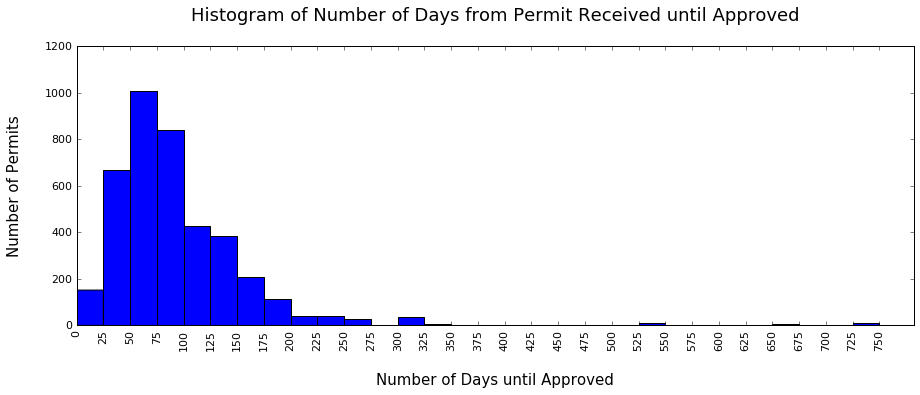

In [70]:
histogram_plot(df_wells, 'Days_Recvd_to_Approval')
plt.title("Histogram of Number of Days from Permit Received until Approved\n");
plt.xlabel("\nNumber of Days until Approved");
plt.ylabel("Number of Permits\n");

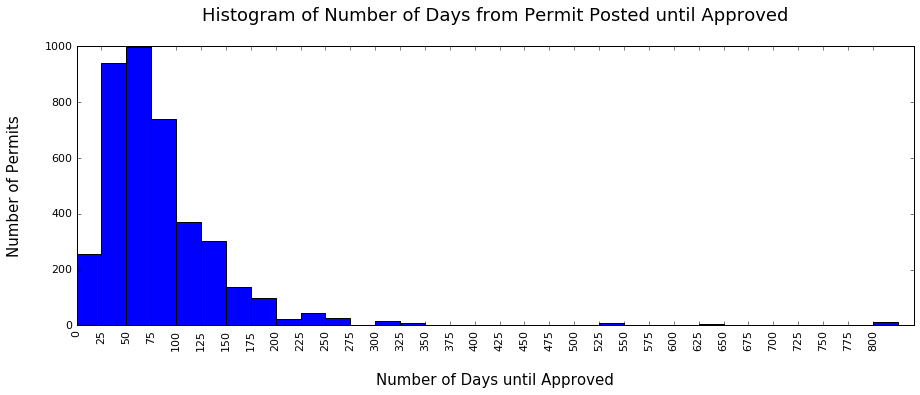

In [71]:
histogram_plot(df_wells, 'Days_Posted_to_Approval')
plt.title("Histogram of Number of Days from Permit Posted until Approved\n");
plt.xlabel("\nNumber of Days until Approved");
plt.ylabel("Number of Permits\n");

In [73]:
# Wells with 0 days from Received to Approved
print("There were {} permits in this time frame that had 0 days until approval.\n"\
                    .format(len(df_wells[df_wells['Days_Recvd_to_Approval'] == 0])))
print("These counties are represented in this subset: {}".format(df_wells[df_wells['Days_Recvd_to_Approval'] == 0]['County'].unique()))
df_wells[df_wells['Days_Recvd_to_Approval'] == 0]

There were 18 permits in this time frame that had 0 days until approval.

These counties are represented in this subset: [u'WELD' u'LA PLATA' u'LARIMER']


,Operator Contact,Type of Permit,Well Name/Number,Objective Formation,Proposed TD,Well Location,Footage Call,Field,County,App_Received,App_Posted,App_Approved,Operator_Name,Operator_Number,Days_Recvd_to_Approval,Days_Posted_to_Approval
163,MattBarber\n(303)312-8188,DR,Peterson\n5-63-30-0758B2,NIOBRARA,16329,NENE305N63W,613FNL792FEL,WATTENBERG\n90750,WELD,2017-06-20,2017-06-20,2017-06-20,BARRETT CORPORATION* BILL,10071,0,0
324,PattiCampbell\n(970)335-3828,DR,Merry Federal\n2,FRUITLAND COAL,5711,NWNE1034N6W,1192FNL1567FEL,IGNACIO BLANCO\n38300,LA PLATA,2017-06-12,2017-06-12,2017-06-12,BP AMERICA PRODUCTION COMPANY,10000,0,0
523,KamrinRuder\n(720)9747743,DR,Johnsons Corner\n13-N,NIOBRARA,17025,SWNE355N68W,2444FNL2458FEL,WATTENBERG\n90750,LARIMER,2017-05-22,2017-05-22,2017-05-22,EXTRACTION OIL & GAS LLC,10459,0,0
919,KamrinRuder\n(720)9747743,DR,RBF\n9,NIOBRARA,16812,SENE226N67W,2073FNL300FEL,WATTENBERG\n90750,WELD,2017-04-27,2017-04-27,2017-04-27,EXTRACTION OIL & GAS LLC,10459,0,0
1797,TyEntenmann\n(720)5578326,DR,Kiteley\n9,CODELL,12088,NWSW213N68W,1369FSL637FWL,WATTENBERG\n90750,WELD,2017-02-09,2017-02-09,2017-02-09,EXTRACTION OIL & GAS LLC,10459,0,0
1851,KamrinRuder\n(720)9747743,DR,TC Country Club West\nC19-11,CODELL,20610,SENE85N66W,2446FNL1195FEL,WATTENBERG\n90750,WELD,2017-02-06,2017-02-06,2017-02-06,EXTRACTION OIL & GAS LLC,10459,0,0
1985,CHERYLLIGHT\n(720)929-6461,DR,JAGUAR\n14N-35HZX,NIOBRARA,17965,SESW231N67W,365FSL1765FWL,WATTENBERG\n90750,WELD,2017-01-12,2017-01-12,2017-01-12,KERR MCGEE OIL & GAS ONSHORE LP,47120,0,0
2406,ErinEkblad\n(720)616.4319,DR,SRC Williams\n11-4-5NM-C,NIOBRARA,13713,NENW44N67W,1002FNL2406FWL,WATTENBERG\n90750,WELD,2016-11-29,2016-11-29,2016-11-29,SYNERGY RESOURCES CORPORATION,10311,0,0
2690,CHERYLLIGHT\n(720)929-6461,DR,HIGHLANDS\n37N-E16HZX,NIOBRARA,14272,NENE91N66W,432FNL1038FEL,WATTENBERG\n90750,WELD,2016-10-24,2016-10-24,2016-10-24,KERR MCGEE OIL & GAS ONSHORE LP,47120,0,0
2768,ErinEkblad\n(720)616.4319,DR,Evans\n24N-14A-L,NIOBRARA,17022,SWNE265N66W,2005FNL2574FEL,WATTENBERG\n90750,WELD,2016-10-17,2016-10-17,2016-10-17,SYNERGY RESOURCES CORPORATION,10311,0,0


In [74]:
# Wells with 365+ days from Received to Approved
print("There were {} permits in this time frame that had 365+ days until approval.\n"\
                    .format(len(df_wells[df_wells['Days_Recvd_to_Approval'] > 365])))
print("These counties are represented in this subset: {}".format(df_wells[df_wells['Days_Recvd_to_Approval'] > 365]['County'].unique()))
df_wells[df_wells['Days_Recvd_to_Approval'] > 365]

There were 30 permits in this time frame that had 365+ days until approval.

These counties are represented in this subset: [u'WELD']


,Operator Contact,Type of Permit,Well Name/Number,Objective Formation,Proposed TD,Well Location,Footage Call,Field,County,App_Received,App_Posted,App_Approved,Operator_Name,Operator_Number,Days_Recvd_to_Approval,Days_Posted_to_Approval
155,ShayelynMarshall\n(720)929-6907,DR,RESOLUTION FED\n12-65-31-6-3NH,NIOBRARA,18454,NWNE3112N65W,556FNL2640FEL,WILDCAT\n99999,WELD,2015-09-11,2015-09-15,2017-06-22,ANADARKO E&P ONSHORE LLC,2800,650,646
156,ShayelynMarshall\n(720)929-6907,DR,RESOLUTION FED\n12-65-31-6-2NH,NIOBRARA,18648,NWNE3112N65W,534FNL2660FEL,WILDCAT\n99999,WELD,2015-09-11,2015-09-15,2017-06-22,ANADARKO E&P ONSHORE LLC,2800,650,646
157,ShayelynMarshall\n(720)929-6907,DR,RESOLUTION FED\n12-65-31-6-4NH,NIOBRARA,18368,NWNE3112N65W,579FNL2621FEL,WILDCAT\n99999,WELD,2015-09-11,2015-09-15,2017-06-22,ANADARKO E&P ONSHORE LLC,2800,650,646
158,ShayelynMarshall\n(720)929-6907,DR,RESOLUTION FED\n12-65-31-6NH,NIOBRARA,19001,NENW3112N65W,511FNL2625FWL,WILDCAT\n99999,WELD,2015-09-11,2015-09-15,2017-06-22,ANADARKO E&P ONSHORE LLC,2800,650,646
159,ShayelynMarshall\n(720)929-6907,DR,RESOLUTION\n12-65-31-6-6NH,NIOBRARA,18319,NWNE3112N65W,330FNL1725FEL,WILDCAT\n99999,WELD,2015-09-11,2015-09-14,2017-06-22,ANADARKO E&P ONSHORE LLC,2800,650,647
160,ShayelynMarshall\n(720)929-6907,DR,RESOLUTION\n12-65-31-6-7NH,NIOBRARA,18374,NWNE3112N65W,330FNL1665FEL,WILDCAT\n99999,WELD,2015-09-11,2015-09-14,2017-06-22,ANADARKO E&P ONSHORE LLC,2800,650,647
312,ChrisMcRickard\n(720)410-8494,DR,Regnier Farms\n1D-19H-B268,NIOBRARA,11923,NWNE192N68W,62FNL1823FEL,WATTENBERG\n90750,WELD,2015-06-11,2015-03-20,2017-06-13,CRESTONE PEAK RESOURCES OPERATING LLC,10633,733,816
313,ChrisMcRickard\n(720)410-8494,DR,Regnier Farms\n1E-19H-B268,CODELL,12060,NWNE192N68W,62FNL1813FEL,WATTENBERG\n90750,WELD,2015-06-11,2015-03-23,2017-06-13,CRESTONE PEAK RESOURCES OPERATING LLC,10633,733,813
314,ChrisMcRickard\n(720)410-8494,DR,Regnier Farms\n1H-19H-B268,CODELL,12125,NWNE192N68W,62FNL1783FEL,WATTENBERG\n90750,WELD,2015-06-11,2015-03-23,2017-06-13,CRESTONE PEAK RESOURCES OPERATING LLC,10633,733,813
315,ChrisMcRickard\n(720)410-8494,DR,Regnier Farms\n1I-19H-B268,NIOBRARA,11931,NWNE192N68W,62FNL1773FEL,WATTENBERG\n90750,WELD,2015-06-11,2015-03-20,2017-06-13,CRESTONE PEAK RESOURCES OPERATING LLC,10633,733,816


In [75]:
# Getting listing of Companies with most well permits approved in this time period
df_wells.groupby('Operator_Name').count()['Well Location'].sort_values(axis=0, ascending=False)

Operator_Name
TEP ROCKY MOUNTAIN LLC                        505
PDC ENERGY INC                                371
EXTRACTION OIL & GAS LLC                      285
WHITING OIL & GAS CORPORATION                 282
KERR MCGEE OIL & GAS ONSHORE LP               252
GREAT WESTERN OPERATING COMPANY LLC           219
VANGUARD OPERATING LLC                        209
NOBLE ENERGY INC                              152
CAERUS PICEANCE LLC                           149
BARRETT CORPORATION* BILL                     142
LARAMIE ENERGY LLC                            125
URSA OPERATING COMPANY LLC                    119
SYNERGY RESOURCES CORPORATION                 111
BP AMERICA PRODUCTION COMPANY                 101
ENCANA OIL & GAS (USA) INC                     93
BONANZA CREEK ENERGY OPERATING COMPANY LLC     76
CAERUS WASHCO LLC                              70
SANDRIDGE EXPLORATION & PRODUCTION LLC         54
EXTRACTION OIL & GAS INC                       51
HRM RESOURCES II LLC                

In [76]:
# Getting number of wells by County
df_wells.groupby('County').count()['Well Location'].sort_values(axis=0, ascending=False)

County
WELD          2272
GARFIELD       948
RIO BLANCO     157
ADAMS          142
MESA           118
LA PLATA       113
JACKSON         54
LARIMER         34
GUNNISON        30
ARAPAHOE        23
MOFFAT          20
MORGAN          15
LINCOLN         14
WASHINGTON      13
MONTEZUMA        8
ELBERT           4
ARCHULETA        4
CROWLEY          3
FREMONT          2
DOLORES          2
BACA             2
LOGAN            2
KIOWA            2
KIT CARSON       1
Name: Well Location, dtype: int64

In [77]:
def line_plot(df, column):
    # Creating line plot
    
    # Setting up display parameters
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', labelsize=12)
    mpl.rcParams.update({'font.size': 15})

    # Plotting Day vs. Average Number of Patients
    x = df.groupby(column).count().index
    y = df.groupby(column).count()['Well Location']

    fig=plt.figure(figsize=(15,7));
    ax=fig.add_subplot(111);
    ax.plot(x, y, color='b', linewidth=1.5);
    plt.xticks(rotation='vertical');

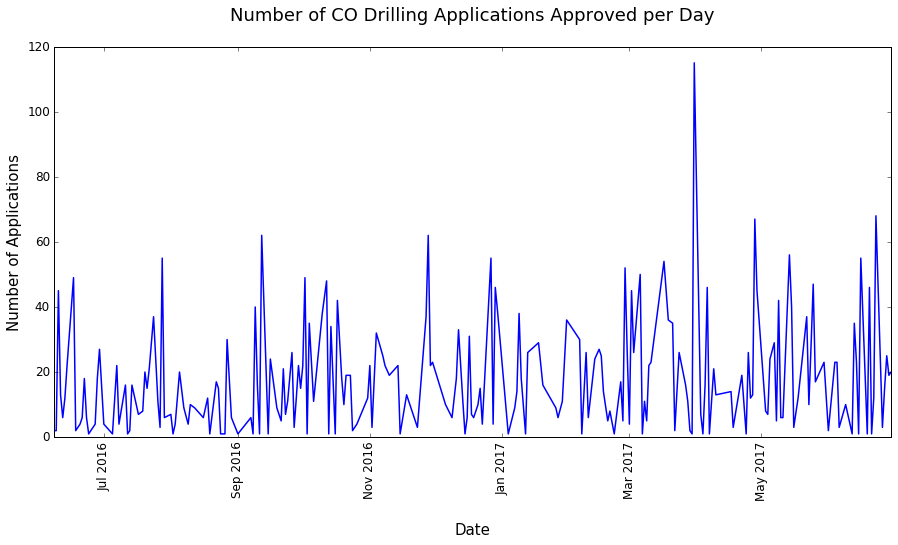

In [78]:
# Plotting the number Number of Drilling Applications Approved per Day in Colorado
line_plot(df_wells, 'App_Approved')
plt.title("Number of CO Drilling Applications Approved per Day\n");
plt.xlabel('\nDate');
plt.ylabel('Number of Applications');

#### Visually, it does appear there is an increase in the trend.
#### Let's apply some Bayesian Probabilistic Programming to gain some more insight.

Thanks to Cameron Davidson-Pilon's 'Bayesian Methods for Hackers' for showing how I can go about doing this.

I see that it makes sense to model the application approval count data per day using a Poisson distribution: 
<center>C<sub>i</sub> ~ Poi( $\lambda$ )</center>

It appears that there is an increasing trend of approval counts per day.
So, we may have a switchpoint where our $\lambda$ may be changing and we have $\lambda$<sub>1</sub> before the increase in approvals and $\lambda$<sub>2</sub> after the increase in approvals.

We can then model $\lambda$<sub>1</sub> and $\lambda$<sub>2</sub> using Exponential distributions.

The Exponential function has a parameter $\alpha$ that I need to model as well: 
<center>$\lambda$<sub>1</sub> ~ Exp($\alpha$)</center>
<center>$\lambda$<sub>2</sub> ~ Exp($\alpha$)</center>

A good rule of thumb is to set the exponential parameter, $\alpha$, equal to the inverse of the average number of applications approved per day as this makes the prior probablility less opinionated up front:
<center>$\alpha$ = $\frac{1}{Ci}$

I'll use a Uniform distribution to model the switchpoint time, $\tau$:
<center> $\tau$ ~ DiscreteUniform(1, Number of Days)</center>

In [80]:
# Number of applications approved per day
apps_per_day = df_wells.groupby('App_Approved').count()['Well Location']

num_days = len(apps_per_day)

# Alpha is a hyperparameter needed for the Exponential Distribution
alpha = 1.0 / apps_per_day.mean()

with pm.Model() as model:
    lambda1 = pm.Exponential("lambda1", alpha)
    lambda2 = pm.Exponential('lambda2', alpha)

    tau = pm.DiscreteUniform('tau', lower=0, upper=num_days-1)
    
    print("Random output: ", tau.random(), tau.random(), tau.random())

('Random output: ', array(212, dtype=int32), array(137, dtype=int32), array(174, dtype=int32))


In [82]:
# The switch() function assigns lambda1 or lambda2 as the value of lambda_, depending on what side of tau we are on. 
# The values of lambda_ up until tau are lambda_1 and the values afterwards are lambda_2.

with model:
    idx = np.arange(num_days) # Index
    lambda_ = pm.math.switch(tau >= idx, lambda1, lambda2)

In [83]:
# The variable obs combines apps_per_day with our proposed data-generation scheme, given by the variable lambda_,
#    through the observed keyword.

with model:
    obs = pm.Poisson("obs", lambda_, observed=apps_per_day)

In [84]:
# Using the Metropolis-Hastings Markov chain Monte Carlo (MCMC) method to obtain a sequence of random samples 
#    from our probability distributions

with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|██████████| 10000/10000 [00:04<00:00, 2223.18it/s]


In [85]:
lambda1_samples = trace['lambda1']
lambda2_samples = trace['lambda2']
tau_samples = trace['tau']

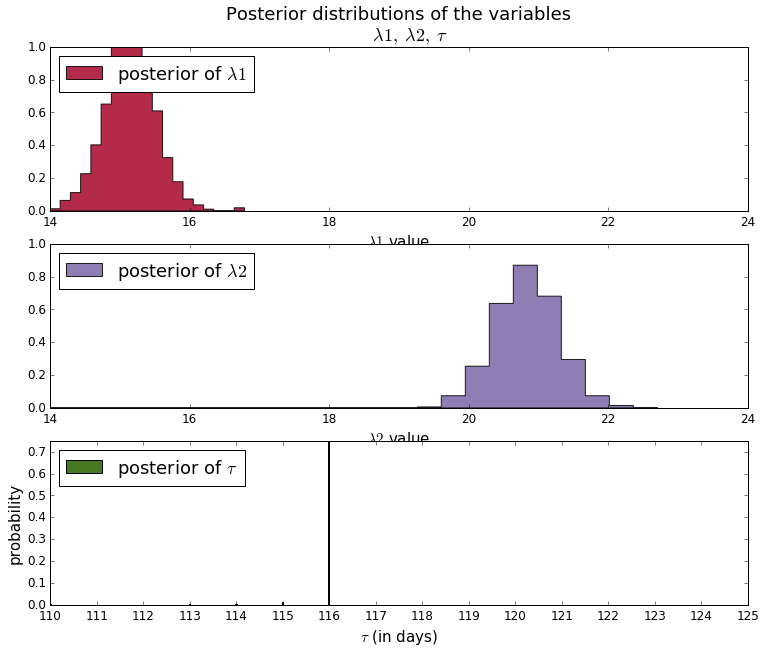

In [86]:
#Plotting histogram of the samples:

fig = plt.figure(figsize=(12.5, 10))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda1,\;\lambda2,\;\tau$""")
plt.xlim([14, 24])
plt.xlabel("$\lambda1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([14, 24])
plt.xlabel("$\lambda2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=num_days, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(num_days))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim(110, 125)
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

#### On Day 116 is when we are seeing the switchpoint.
#### What day is that?

In [87]:
# Because Days of Approval do not contain weekends/holidays and such, we need to find the 116th day in our list 
#    of actual approval days
switchpoint_day = sorted(df_wells['App_Approved'].unique())[116]
print("The day where we observe a switchpoint, or increase in average number of permits approved, is {}"\
       .format(switchpoint_day))


The day where we observe a switchpoint, or increase in average number of permits approved, is 2016-12-23T00:00:00.000000000


#### December 23, 2016 => This is probably the last day of work for the year for most people, right before the holidays

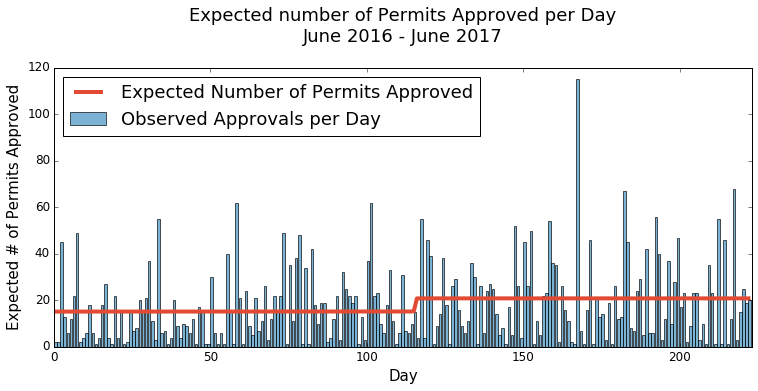

In [101]:
# Plotting the application counts per day with the Expected Value of Applications Approved per Day graphed on top.

fig = plt.figure(figsize=(12.5, 5))
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution

N = tau_samples.shape[0]
expected_approvals_per_day = np.zeros(num_days)
for day in range(0, num_days):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # For each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # The "application count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "application count".
    expected_approvals_per_day[day] = (lambda1_samples[ix].sum()
                                   + lambda2_samples[~ix].sum()) / N


plt.plot(range(num_days), expected_approvals_per_day, lw=4, color="#E24A33",
         label="Expected Number of Permits Approved")
plt.xlim(0, num_days)
plt.xlabel("Day")
plt.ylabel("Expected # of Permits Approved")
plt.title("Expected number of Permits Approved per Day\nJune 2016 - June 2017\n")
# plt.ylim(0, 60)
plt.bar(np.arange(len(apps_per_day)), apps_per_day, color="#348ABD", alpha=0.65,
        label="Observed Approvals per Day")

plt.legend(loc="upper left");

In [102]:
print df_wells['App_Approved'].unique()

['2017-06-30T00:00:00.000000000' '2017-06-29T00:00:00.000000000'
 '2017-06-28T00:00:00.000000000' '2017-06-27T00:00:00.000000000'
 '2017-06-26T00:00:00.000000000' '2017-06-23T00:00:00.000000000'
 '2017-06-22T00:00:00.000000000' '2017-06-21T00:00:00.000000000'
 '2017-06-20T00:00:00.000000000' '2017-06-19T00:00:00.000000000'
 '2017-06-16T00:00:00.000000000' '2017-06-15T00:00:00.000000000'
 '2017-06-14T00:00:00.000000000' '2017-06-13T00:00:00.000000000'
 '2017-06-12T00:00:00.000000000' '2017-06-09T00:00:00.000000000'
 '2017-06-06T00:00:00.000000000' '2017-06-05T00:00:00.000000000'
 '2017-06-04T00:00:00.000000000' '2017-06-02T00:00:00.000000000'
 '2017-06-01T00:00:00.000000000' '2017-05-30T00:00:00.000000000'
 '2017-05-26T00:00:00.000000000' '2017-05-25T00:00:00.000000000'
 '2017-05-24T00:00:00.000000000' '2017-05-23T00:00:00.000000000'
 '2017-05-22T00:00:00.000000000' '2017-05-18T00:00:00.000000000'
 '2017-05-16T00:00:00.000000000' '2017-05-15T00:00:00.000000000'
 '2017-05-14T00:00:00.000